In [205]:
# standard libs
import os
import sys
import logging
from functools import partial

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
import geometry
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
from preprocessing import *
from preparation import *
from spatial_autocorrelation import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt
import libpysal as lps
from esda.moran import Moran, Moran_Local

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='pandas.Int64Index is deprecated')
logging.captureWarnings(True)

In [5]:
%load_ext autoreload
%autoreload 2

## Data

In [ ]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [177]:
gdf_nl = utils.load_data('netherlands', geo=True)
gdf_nl_sample = utils.sample_cities(gdf_nl, 0.1)


In [15]:
path_data_netherlands = os.path.join('..', 'data', 'prepared', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands[data_netherlands['city'].isin(['Apeldoorn', 'Harlingen', 'Vlieland'])] #.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
df_nl_geo = geometry.add_geometry_column(data_netherlands_sample, crs=28992, countries=['netherlands'])
gdf_nl = geometry.to_gdf(df_nl_geo, crs=28992)
gdf_nl.dropna(subset=['geometry'], inplace=True)


2022-03-21 13:26:32,721 | WARNING : Dataset is already a GeoDataFrame. Skipping convertion.


## Preprocessing

### Visual validation of city-based TouchesIndexes

In [ ]:
# TouchesIndexes correspond to city-wide indices of splitting data
df = gdf_nl.copy()
df['old_block'] = df.groupby('TouchesIndexes').ngroup()
df['block'] = df.groupby(['city', 'TouchesIndexes']).ngroup()

print(len(df['block'].unique()))
print(len(df['old_block'].unique()))

df[df['city'] == 'Vlieland'].plot('block', aspect=1)
df[df['city'] == 'Vlieland'].plot('old_block', aspect=1)

In [199]:
df = gdf_nl.copy()

# Approach 1 (super slow)
def add_block_building_ids_column(df):
    def global_touches_indexes(df):
        df['block_bld_ids'] = df['id'].values
        return df

    df['block'] = df.groupby(['city', 'TouchesIndexes']).ngroup()
    df.groupby('block').apply(global_touches_indexes)
    return df

# Approach 2 (quite fast)
def add_block_building_ids_column(df):
    df['block'] = df.groupby(['city', 'TouchesIndexes']).ngroup()
    block_building_ids = df.groupby('block')['id'].apply(list).to_dict()
    df['block_bld_ids'] = df['block'].map(block_building_ids)
    return df

# Approach 3 (not working)
# d = df.groupby(['city', 'TouchesIndexes'])['id'].apply(list).to_dict()
# d = {tuple((k[0], eval(k[1]))): v for k, v, in d.items()}
# df['block_bld_ids'] = pd.Series(zip(df['city'], df['TouchesIndexes'])).map(d)

df = add_block_building_ids_column(df)
df[['id', 'TouchesIndexes', 'block_bld_ids']]


,id,TouchesIndexes,GlobalTouchesIndexes
index,,,
23006,9134081,[0],[9134081]
23007,12084333,"[1, 36489]","[12084333, 12084409]"
23008,6432921,"[2, 12640, 31541, 27394, 20200, 1350]","[6432921, 6431841, 6433177, 6432888, 6432868, ..."
23009,6438456,"[3, 37325, 40505, 20195, 5033, 37994, 1865, 14...","[6438456, 6438376, 6432833, 6440613, 6438722, ..."
23010,6440119,"[4, 19911, 28795, 37437, 26172, 33841, 3048, 2...","[6440119, 6434015, 6440239, 6440207, 6436316, ..."
...,...,...,...
1106838,15549209,[102656],[15549209]
1106839,18034055,"[58705, 102657]","[18034052, 18034055]"
1106840,8771270,"[15517, 19985, 70594, 102102, 102658]","[8275911, 8771275, 8275909, 8771272, 8771270]"


In [181]:
# Validation: how many block_bld_ids do not correspond to TouchesIndexes?
# Counter([len(eval(k[1])) == len(v) for k, v in d.items()])
# df.dropna(subset='block_bld_ids', inplace=True) # should not include nan values
df.apply(lambda x: len(eval(x['TouchesIndexes'])) == len(x['block_bld_ids']), axis=1).value_counts()


False    155371
dtype: int64

## Experiments

### Spatial autocorrelation measure Moran's I for different weights / neighborhood matrices

In [40]:
# compute spatial weights

logging.disable(logging.NOTSET)
# df = gdf_nl[gdf_nl['city'] == 'Vlieland'].reset_index(drop=True)
# df = utils.sample_cities(data_netherlands, 0.1)
# df = geometry.add_geometry_column(df, crs=28992, countries=['netherlands'])
# df = add_street_block_column(df)
# df = add_block_column(df)

df = utils.sample_cities(gdf_nl, 0.3)
df = add_block_building_ids_column(df)
df = add_sbb_building_ids_column(df)
df = add_neighborhood_column(df)

for distance in [10, 25, 50, 100, 250, 500]:
    print(distance, moran_distance(df, distance_threshold=distance).I)


# {k:v for k,v in neighbors.items() if not v.remove(k) and v}


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


distance_weights 0.626172667742779
knn_weights 0.5928854819323085
within_sbb_weights 0.04017201966452152
within_block_weights 0.31648735803044187
between_sbbs_weights 0.02105038624230057
between_blocks_weights 0.0240460256886511
10 0.6397879775677477
25 0.6100871785664473
50 0.5488183333419058
100 0.47229509686259397
250 0.3683809794407626
500 0.289841035944549


In [179]:
df_2 = utils.sample_cities(gdf_nl, 0.1)
df_2 = add_block_building_ids_column(df_2)
df_2 = add_sbb_building_ids_column(df_2)
df_2 = add_neighborhood_column(df_2)

2022-04-26 11:59:03,754 | WARNING : 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2022-04-26 11:59:03,830 | WARNING : 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2022-04-26 11:59:23,421 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 11:59:26,721 | INFO : On average 7 street blocks have been assigned per neighborbood cluster.
2022-04-26 11:59:26,734 | WARNING : 
A value is trying to be set on a copy of a slic

In [9]:
print('distance_weights', moran_distance(df).I)
print('knn_weights', moran_knn(df).I)
print('within_sbb_weights', moran_within_sbb(df).I)
print('within_block_weights', moran_within_block(df).I)
print('between_sbbs_weights', moran_between_sbbs(df).I)
print('between_blocks_weights', moran_between_blocks(df).I)

distance_weights 0.5773888940578187
knn_weights 0.5627528631344536
within_sbb_weights 0.332853331778207
within_block_weights 0.6323043074561889
between_sbbs_weights 0.2658110081288001
between_blocks_weights 0.5169480887514382


In [15]:
# print('50m distance_weights excluding block', moran_distance(df, distance_threshold=50, exc_block_type='block').I)
# print('test baseline: 50m distance_weights not excluding block', moran_distance(df, distance_threshold=50).I)

# print('100m distance_weights excluding sbb', moran_distance(df, distance_threshold=100, exc_block_type='sbb').I)
# print('test baseline: 100m distance_weights not excluding sbb', moran_distance(df, distance_threshold=100).I)

print('500m distance_weights excluding neighborhood', moran_distance(df, distance_threshold=500, exc_block_type='neighborhood').I)
print('test baseline: 500m distance_weights not excluding neighborhood', moran_distance(df, distance_threshold=500).I)


500m distance_weights excluding sbb 0.1049781540323975
test baseline: 500m distance_weights not excluding sbb 0.21939748514287855


In [19]:
print('1000m distance_weights excluding neighborhood', moran_distance(df, distance_threshold=1000, exc_block_type='neighborhood').I)
print('test baseline: 1000m distance_weights not excluding neighborhood', moran_distance(df, distance_threshold=1000).I)

1000m distance_weights excluding sbb 0.08393418918419346
test baseline: 1000m distance_weights not excluding sbb 0.1416833871504988


In [7]:
print('100m distance_weights excluding sbb', moran_distance(df, distance_threshold=100, exc_block_type='sbb').I)
print('test baseline: 100m distance_weights not excluding sbb', moran_distance(df, distance_threshold=100).I)


100m distance_weights excluding sbb 0.3342391571035327
test baseline: 100m distance_weights not excluding sbb 0.44417817836606727


In [8]:
print('500m distance_weights excluding sbb', moran_distance(df, distance_threshold=500, exc_block_type='sbb').I)
print('test baseline: 500m distance_weights not excluding sbb', moran_distance(df, distance_threshold=500).I)


500m distance_weights excluding sbb 0.1947327536044914
test baseline: 500m distance_weights not excluding sbb 0.21939748514287855


In [55]:
gdf_nl_sample = df[df['city'] == 'Borculo']
df_train, df_test = split_80_20(gdf_nl_sample)
print('between test & training split', moran_between_groups(df_train, df_test).I)


between test & training split -2.4337364439216948e-05


In [49]:

print('500m distance_weights excluding city', moran_distance(df, distance_threshold=500, exc_block_type='city').I)
# print('test baseline: 500m distance_weights not excluding city', moran_distance(df, distance_threshold=500).I)


2022-04-21 12:34:39,399 | WARNING : invalid value encountered in double_scalars

2022-04-21 12:34:39,405 | WARNING : invalid value encountered in double_scalars

2022-04-21 12:34:39,407 | WARNING : divide by zero encountered in double_scalars

2022-04-21 12:34:39,407 | WARNING : invalid value encountered in double_scalars



500m distance_weights excluding city nan


In [12]:
print('50m distance_weights including outliers', moran_distance(gdf_nl_sample, distance_threshold=50).I)
print('50m distance_weights excluding outliers', moran_distance(remove_buildings_pre_1900(gdf_nl_sample), distance_threshold=50).I)


50m distance_weights including outliers 0.5295465804662018
50m distance_weights excluding outliers 0.5748330838266285


### Moran's I for features

In [276]:
# compute Moran's I for the age
gdf_nl_sample = gdf_nl[gdf_nl['city'] == 'Vlieland'].reset_index(drop=True)

features_moran_I(gdf_nl_sample, distance_weights)
# print(mi.I)
# print(mi.p_sim)



invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in true_divide
invalid value encountered in double_scalars


,feature,moran_I,moran_p
72,BlockLength,1.133566,0.001
16,BlockCorners,1.022379,0.001
92,av_area_block_city,1.000000,0.001
80,std_building_footprint_city,1.000000,0.001
82,total_length_street_city,1.000000,0.001
...,...,...,...
86,intersections_count,NaN,0.001
100,blocks_2_to_4,NaN,0.001
101,blocks_20_to_inf,NaN,0.001
108,av_building_footprint_city,NaN,0.001


2022-03-30 19:13:57,661 | WARNING : 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2022-03-30 19:13:57,791 | WARNING : 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,age,height,lat,lon,Orientation
10,0.557637,0.897019,0.993926,1.18347,1.009897
25,0.588519,0.183179,0.996392,1.04266,0.892230


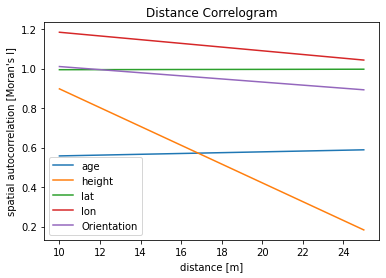

In [13]:
gdf = gdf_nl_sample
scaler = preprocessing.MinMaxScaler()
gdf[['lat', 'lon']] = scaler.fit_transform(gdf[['lat', 'lon']])
gdf.dropna(subset=['age', 'height', 'lat', 'lon', 'Orientation'], inplace=True)
plot_correlogram_over_distance(gdf, attributes=['age', 'height', 'lat', 'lon', 'Orientation'], distances=[10,25])

In [46]:
df.city.unique()

array(['Borculo', 'Barneveld', 'Bolsward', 'Schiermonnikoog',
       'Doetinchem'], dtype=object)

In [48]:
gdf_nl_sample = df[df['city'] == 'Borculo'].reset_index(drop=True)

df.dropna(subset=dataset.BUILDING_FEATURES, inplace=True)
plot_correlogram_over_distance(df, attributes=dataset.BUILDING_FEATURES, distances=[10,25,50, 100])

,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,SharedWallLength,lat,lon
10,0.041872,0.170706,0.604128,0.198703,0.489499,0.391757,1.009897,0.197128,0.778041,0.836839,0.993926,1.183470
25,0.037489,0.126442,0.276161,0.155120,0.242225,0.241788,0.892230,0.148147,0.526616,0.458460,0.996392,1.042660
50,0.096148,0.215489,0.191973,0.264734,0.168250,0.170639,0.807515,0.136371,0.472711,0.391260,0.999493,1.005845
100,0.197067,0.267725,0.132652,0.314752,0.113923,0.124926,0.693374,0.118384,0.409811,0.301814,0.999747,1.001121


In [ ]:
# visual validation
%matplotlib qt
from splot.esda import lisa_cluster, plot_moran
from splot.libpysal import plot_spatial_weights

plot_spatial_weights(dis, gdf_nl_sample, indexed_on='id')
m = Moran(gdf_nl_sample['total_ft_area_within_buffer_500'], dis)
plot_moran(m, zstandard=True, figsize=(12,6))

m_local = Moran_Local(gdf_nl_sample['age'], dis)
fig, ax = plt.subplots(figsize=(12,10))
lisa_cluster(m_local, gdf_nl_sample, p=0.05, ax=ax, aspect=1)
# gdf_nl_sample.boundary.plot(ax=ax)
plt.title('Vlieland spatial age Lag Choropleth Map')
# plt.tight_layout()
plt.show()
# %matplotlib inline

In [128]:
from splot.esda import plot_local_autocorrelation, lisa_cluster
gdf_nl_sample_vlieland = gdf_nl_sample[gdf_nl_sample['city'] == 'Vlieland'].reset_index(drop=True)
dis = spatial_autocorrelation._knn_weights(gdf_nl_sample_vlieland, k=4)
m_local = Moran_Local(gdf_nl_sample_vlieland['age'], dis)
# plot_local_autocorrelation(m_local, gdf_nl_sample_vlieland, 'age', p=0.05,
                                #  region_column='sbb',
                                #  mask=['128204'], quadrant=1)


lisa_cluster(m_local, gdf_nl_sample_vlieland, p=0.05, aspect=1)



(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

### Choice of reasonable distance threshold

In [29]:
from splot.libpysal import plot_spatial_weights
import spatial_autocorrelation
%matplotlib qt

gdf_nl_sample = gdf_nl[gdf_nl['city'] == 'Vlieland'].reset_index(drop=True)

for distance in [15, 50, 100]:
    dis = spatial_autocorrelation._distance_weights(gdf_nl_sample, distance_threshold=distance)
    plot_spatial_weights(dis, gdf_nl_sample)

# 5: too small (neighboring buildings are not connected)
# 10: only very close neighboring buildings are connected
# 15: neighboring buildings are connected
# 20+: more neighboring buildings are connected

# -> do we want to have all neighboring buildings to be connected with one another; or 

In [112]:
from splot.libpysal import plot_spatial_weights
import spatial_autocorrelation
%matplotlib qt

# dataset for analysis
gdf_nl_sample = utils.sample_cities(data_netherlands, 0.1)
gdf_nl_sample = geometry.add_geometry_column(gdf_nl_sample, crs=28992, countries=['netherlands'])
gdf_nl_sample = add_street_block_column(gdf_nl_sample)
gdf_nl_sample = add_block_column(gdf_nl_sample)


# histogram of number of neighbors
dis_sbb = spatial_autocorrelation._between_sbbs_weights(gdf_nl_sample) # 100m distance -> <15% have no neighbors, 50m distance -> <45% have no neighbors
dis_block = spatial_autocorrelation._between_blocks_weights(gdf_nl_sample) # 50m distance -> <11% have no neighbors, 30m distance -> <25% have no neighbors,

n_neighbors_sbb = pd.Series(len(l) for l in dis_sbb.neighbors.values())
n_neighbors_block = pd.Series(len(l) for l in dis_block.neighbors.values())
utils.custom_round(n_neighbors_sbb, base=10).value_counts(normalize=True).sort_index().plot(kind='bar')
utils.custom_round(n_neighbors_block, base=5).value_counts(normalize=True).sort_index().plot(kind='bar')


# visualization
gdf_nl_sample_vlieland = gdf_nl_sample[gdf_nl_sample['city'] == 'Vlieland'].reset_index(drop=True)
dis_sbb_vlieland = spatial_autocorrelation._between_sbbs_weights(gdf_nl_sample_vlieland)
dis_block_vlieland = spatial_autocorrelation._between_blocks_weights(gdf_nl_sample_vlieland)
plot_spatial_weights(dis_sbb_vlieland, gdf_nl_sample_vlieland.sample(frac=.01), indexed_on='id')
plot_spatial_weights(dis_block_vlieland, gdf_nl_sample_vlieland, indexed_on='id')


def plot_few_spatial_weights(weights, gdf, every_n=100):
    few_ids = list(weights.neighbors.keys())[dataset.GLOBAL_REPRODUCIBILITY_SEED::every_n]
    few_neighbors = {k: v for k, v in weights.neighbors.items() if k in few_ids}
    few_dis = lps.weights.W(few_neighbors, ids=few_neighbors.keys(), silence_warnings=True)
    plot_spatial_weights(few_dis, gdf, indexed_on='id')


# plot_few_spatial_weights(dis_block_vlieland, gdf_nl_sample_vlieland)
plot_few_spatial_weights(dis_sbb_vlieland, gdf_nl_sample_vlieland, every_n=1000)


### Autocorrelation between blocks

In [ ]:
df = gdf_nl[gdf_nl['city'] == 'Vlieland'].reset_index(drop=True)

print('within_sbb_weights', moran_within_sbb(df).I)
print('within_block_weights', moran_within_block(df).I)
print('between_sbbs_weights', moran_between_sbbs(df).I)
print('between_blocks_weights', moran_between_blocks(df).I)


### Autocorrelation between other attributes (height, type, etc.)

In [16]:
# df = gdf_nl[gdf_nl['city'] == 'Vlieland'].reset_index(drop=True)

print(moran_knn(gdf_nl, attribute='age').I)
print(moran_knn(gdf_nl, attribute='height').I)
# print(moran_knn(df, attribute='type').I) # not defined for NL

0.5630628617490488
0.42149036684873165


### Autocorrelation between prediction residuals

### Impact of spatial cross-validation on autocorrelation between prediction residuals

In [12]:
len(utils.sample_cities(data_netherlands, 0.5)) / len(data_netherlands)


0.46696431173700775

In [17]:
comparison_config = {
    'spatial city cv': {'cross_validation_split': city_cross_validation, 'test_training_split': None},
    # 'spatial sbb cv': {'cross_validatalidaion_split': sbb_cross_validation, 'test_training_split': None},
    # 'spatial block cv': {'cross_vtion_split': block_cross_validation, 'test_training_split': None},
    'neighborhood cv': {'cross_validation_split': neighborhood_cross_validation, 'test_training_split': None},
    'random cv': {'cross_validation_split': cross_validation, 'test_training_split': None},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=utils.sample_cities(gdf_nl, 0.4),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
)



2022-03-30 20:09:41,535 | INFO : Dataset length: 254150
2022-03-30 20:09:41,864 | INFO : Dataset standard deviation: 37.11071757509423
2022-03-30 20:09:41,865 | INFO : Dataset mean age: 1969.5691914223883
2022-03-30 20:09:41,866 | INFO : Training dataset length: 203320
2022-03-30 20:09:41,867 | INFO : Test dataset length: 50830
2022-03-30 20:09:42,726 | INFO : Test dataset standard deviation after preprocessing: 27.612406739810325
2022-03-30 20:09:42,729 | INFO : Test dataset mean age after preprocessing: 1972.9447863903295
2022-03-30 20:09:42,730 | INFO : Training dataset length after preprocessing: 198351
2022-03-30 20:09:42,730 | INFO : Test dataset length after preprocessing: 49553
2022-03-30 20:10:23,735 | INFO : Starting experiment spatial city cv_...
2022-03-30 20:10:24,209 | INFO : Dataset length: 254150
2022-03-30 20:10:24,413 | INFO : Dataset standard deviation: 37.11071757509423
2022-03-30 20:10:24,414 | INFO : Dataset mean age: 1969.5691914223883
2022-03-30 20:10:24,414 | I

In [18]:
results = comparison.evaluate(include_spatial_autocorrelation=True)
results

2022-03-30 20:36:14,882 | INFO : Moran I for spatial autocorrelation of error: 0.1302 (knn weights with p value of 0.0000)
2022-03-30 20:36:17,485 | INFO : Moran I for spatial autocorrelation of error: 0.3166 (block weights with p value of 0.0000)
2022-03-30 20:36:25,091 | INFO : Moran I for spatial autocorrelation of error: 0.2678 (distance weights with p value of 0.0000)
2022-03-30 20:36:37,127 | INFO : Moran I for spatial autocorrelation of age: 0.8205 (knn weights with p value of 0.0000)
2022-03-30 20:36:40,150 | INFO : Moran I for spatial autocorrelation of age: 1.3163 (block weights with p value of 0.0000)
2022-03-30 20:36:48,435 | INFO : Moran I for spatial autocorrelation of age: 1.0152 (distance weights with p value of 0.0000)
2022-03-30 20:37:26,716 | INFO : Moran I for spatial autocorrelation of error: 0.5581 (knn weights with p value of 0.0000)
2022-03-30 20:37:42,026 | INFO : Moran I for spatial autocorrelation of error: 0.6966 (block weights with p value of 0.0000)
2022-0

,name,R2,MAE,RMSE,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
1,spatial city cv_,0.228689,18.974426,24.221673,0.558100,0.696583,0.623413,0.829617,1.010538,0.880404
2,neighborhood cv_,0.362303,16.376800,22.024029,0.485898,0.602829,0.538674,0.847356,1.100374,0.937994
3,random cv_,0.552605,12.331279,18.447390,0.237806,0.338671,0.272465,0.852057,1.106927,0.957263
0,baseline,0.556987,12.251135,18.378411,0.130167,0.316552,0.267826,0.820548,1.316344,1.015229


In [104]:
results = comparison.evaluate(include_spatial_autocorrelation=True)
results

2022-03-28 12:55:23,369 | INFO : Moran I for spatial autocorrelation of error: 0.13016660050361156 (knn weights with p value of 0.0)
2022-03-28 12:55:25,607 | INFO : Moran I for spatial autocorrelation of error: 0.31655165840909927 (block weights with p value of 0.0)
2022-03-28 12:55:32,152 | INFO : Moran I for spatial autocorrelation of error: 0.26782552478127375 (distance weights with p value of 0.0)
2022-03-28 12:55:38,809 | INFO : Moran I for spatial autocorrelation of age: 0.8205476507733903 (knn weights with p value of 0.0)
2022-03-28 12:55:41,730 | INFO : Moran I for spatial autocorrelation of age: 1.3163437672289078 (block weights with p value of 0.0)
2022-03-28 12:55:48,809 | INFO : Moran I for spatial autocorrelation of age: 1.015229131056468 (distance weights with p value of 0.0)
2022-03-28 12:56:22,927 | INFO : Moran I for spatial autocorrelation of error: 0.5581002759976459 (knn weights with p value of 0.0)
2022-03-28 12:56:36,595 | INFO : Moran I for spatial autocorrelati

,name,R2,MAE,RMSE,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
0,baseline,0.556987,12.251135,18.378411,0.130167,0.316552,0.267826,0.820548,1.316344,1.015229
1,spatial city cv_,0.228689,18.974426,24.221673,0.558100,0.696583,0.623413,0.829617,1.010538,0.880404
2,random cv_,0.552605,12.331279,18.447390,0.237806,0.338671,0.272465,0.852057,1.106927,0.957263


In [132]:
results = comparison.evaluate(include_spatial_autocorrelation=True)
results.sort_values(by='prediction_moranI_KNN')


,name,R2,MAE,RMSE,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
1,spatial city cv_,0.205404,17.622486,22.834834,0.475990,0.288951,0.547521,0.659267,0.314472,0.647147
0,baseline,0.509402,11.550400,17.817017,0.087796,0.395779,0.167177,0.673088,0.390910,0.714030
3,random cv_,0.507848,11.667735,17.971086,0.137721,0.284775,0.197593,0.755610,0.286805,0.793215
2,spatial block cv_,0.485771,12.135400,18.369736,0.178268,0.286709,0.261204,0.760033,0.282833,0.793443


### Autocorrelation between prediction residuals for models trained with subset of features

In [49]:
logging.disable(logging.WARN)

comparison_config = {
    'only building': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.BUILDING_FEATURES)]},
    'only building + block': {'preprocessing_stages': [remove_buildings_pre_1900, partial(filter_features, selection=dataset.BLOCK_FEATURES+dataset.BUILDING_FEATURES)]},
    'no buffer features': {'preprocessing_stages': [remove_buildings_pre_1900, partial(drop_features, regex='buffer_')]},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=gdf_nl_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [50]:
comparison.evaluate_comparison(include_spatial_autocorrelation=True)

,name,R2,MAE,RMSE,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
1,only building_,0.400383,13.438309,19.676659,0.134988,0.413080,0.281933,0.754890,0.401716,0.940123
2,only building + block_,0.413206,13.262324,19.465128,0.129456,0.409797,0.263254,0.732816,0.391376,0.950060
3,no buffer features_,0.457586,12.492512,18.714579,0.082635,0.409838,0.214478,0.750788,0.413356,0.938152
0,baseline,0.484167,11.969770,18.250266,0.068640,0.410713,0.208840,0.761749,0.414005,0.914670


## Other Experiments

In [182]:
# import warnings

# warnings.filterwarnings("ignore", message='pandas.Int64Index is deprecated')
# df_sample = data_netherlands_sample[data_netherlands_sample['id'].isin(gdf_nl['id'].values)].reset_index(drop=True)
# df_sample = df_sample[df_sample['city'] == 'Vlieland'].reset_index(drop=True)

predictor = AgePredictor(
    model=XGBRegressor(),
    df=utils.sample_cities(gdf_nl, 0.1),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_outliers]
)

predictor.individual_prediction_error()
# predictor.spatial_autocorrelation_moran('error', 'knn').I
# predictor.spatial_autocorrelation_moran('age', 'knn').I

2022-03-28 15:32:52,249 | INFO : Dataset length: 81652
2022-03-28 15:32:52,311 | INFO : Dataset standard deviation: 32.724917318050515
2022-03-28 15:32:52,312 | INFO : Dataset mean age: 1973.7581320726988
2022-03-28 15:32:52,313 | INFO : Training dataset length: 65321
2022-03-28 15:32:52,314 | INFO : Test dataset length: 16331
2022-03-28 15:32:52,605 | INFO : Test dataset standard deviation after preprocessing: 25.26322618556549
2022-03-28 15:32:52,606 | INFO : Test dataset mean age after preprocessing: 1976.4474854387174
2022-03-28 15:32:52,606 | INFO : Training dataset length after preprocessing: 63846
2022-03-28 15:32:52,607 | INFO : Test dataset length after preprocessing: 15967


,error
id,
4873638,-12.090088
2912572,1.826782
3410970,1.384155
14321705,-13.982910
1367572,-41.561401
...,...
2912694,7.632446
1181447,-13.468872
7301014,25.919312


In [183]:
# (predictor.y_predict - predictor.y_test)
# predictor.individual_prediction_error()
predictor.spatial_autocorrelation_moran('age', 'block').I


2022-03-28 15:33:06,626 | INFO : Moran I for spatial autocorrelation of age: 1.0055 (block weights with p value of 0.0000)


1.0055219652152354

In [429]:
# comparison.evaluate_comparison(include_spatial_autocorrelation=True)
# comparison.predictors['random cv_'].spatial_autocorrelation_moran('age', 'knn').I
# comparison.predictors['spatial city cv_'].spatial_autocorrelation_moran('age', 'knn').I
# comparison.predictors['spatial city cv_'].spatial_autocorrelation_moran('age', 'block').I
# comparison.predictors['baseline'].spatial_autocorrelation_moran('age', 'block').I
# comparison.predictors['random cv_'].do_across_folds(predictor.print_model_error)
comparison.predictors['random cv_'].mae(across_folds=True)
# comparison.predictors['random cv_'].rmse(across_folds=True)
# import prediction 
# comparison.predictors['random cv_'].do_across_folds(prediction.Predictor.mae)

TypeError: mae() got an unexpected keyword argument 'across_folds'

In [428]:
comparison_config = {
    # 'spatial city cv': {'cross_validation_split': city_cross_validation, 'test_training_split': None},
    # 'spatial sbb cv': {'cross_validatalidaion_split': sbb_cross_validation, 'test_training_split': None},
    # 'spatial block cv': {'cross_vtion_split': block_cross_validation, 'test_training_split': None},
    'random cv': {'cross_validation_split': cross_validation, 'test_training_split': None},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=gdf_nl_sample.sample(frac=0.1),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
)



2022-03-30 09:51:39,500 | INFO : Dataset length: 8165
2022-03-30 09:51:39,550 | INFO : Dataset standard deviation: 34.03001679777921
2022-03-30 09:51:39,551 | INFO : Dataset mean age: 1973.6728720146968
2022-03-30 09:51:39,552 | INFO : Training dataset length: 6532
2022-03-30 09:51:39,552 | INFO : Test dataset length: 1633
2022-03-30 09:51:39,687 | INFO : Test dataset standard deviation after preprocessing: 25.846269683131656
2022-03-30 09:51:39,687 | INFO : Test dataset mean age after preprocessing: 1975.590570719603
2022-03-30 09:51:39,688 | INFO : Training dataset length after preprocessing: 6430
2022-03-30 09:51:39,689 | INFO : Test dataset length after preprocessing: 1612
2022-03-30 09:51:41,106 | INFO : Starting experiment random cv_...
2022-03-30 09:51:41,226 | INFO : Dataset length: 8165
2022-03-30 09:51:41,247 | INFO : Dataset standard deviation: 34.03001679777921
2022-03-30 09:51:41,248 | INFO : Dataset mean age: 1973.6728720146968
2022-03-30 09:51:41,248 | INFO : Training da

In [72]:
logging.disable(logging.WARN)

comparison_config = {
    'one building per block': {'preprocessing_stages': [remove_buildings_pre_1900, keep_only_one_building_per_block]},
    'one building per sbb': {'preprocessing_stages': [remove_buildings_pre_1900, keep_only_one_building_per_sbb]},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=gdf_nl_sample,
    test_training_split=split_by_city,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
)
comparison.evaluate_comparison(include_spatial_autocorrelation=True)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid val

,name,R2,MAE,RMSE,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
2,one building per sbb_,-0.828093,32.326660,37.951484,-0.162299,NaN,NaN,0.135631,NaN,NaN
0,baseline,0.003399,19.568786,24.064115,0.338235,0.478172,0.409900,0.596656,0.393614,0.645816
1,one building per block_,0.106582,17.573675,22.327628,0.256070,NaN,0.304177,0.435165,NaN,0.387526


In [44]:
# knn can be used to determine neighbors, store them and later pass them to lps.weights.W to calculate Moran I
# note: id_order has strong influence of I value

# moran_knn(df.reset_index(drop=True), attribute='age', k=10).I
# moran_distance(residuals_gdf, attribute='error').I
ids = gdf_nl_sample.id.values
knn_4_weights = lps.weights.distance.KNN.from_dataframe(gdf_nl_sample, ids=ids, k=4, silence_warnings=True)
neighbors = knn_4_weights.neighbors
weights = lps.weights.W(neighbors, id_order=ids, silence_warnings=True)

print(Moran(gdf_nl_sample['age'], weights).I)
print(Moran(gdf_nl_sample['age'], knn_4_weights).I)

0.011413672937346875
0.5627528631344536


In [1]:
knn_4_weights.neighbors == weights.neighbors
knn_4_weights.weights == weights.weights


NameError: name 'knn_4_weights' is not defined

In [330]:
type(gdf_nl_sample['block_bld_ids'].values[0])
type(gdf_nl_sample['id'].values[0])
gdf_nl_sample['id'].dtype

dtype('int64')

In [ ]:
# spatial autocorrelation is significantly (~factor 10) smaller between buildings within and nearby blocks
# visual validate that
# prepare dataset to include more aux variables, e.g. k nearest neighbors and sbb ids
# plot autocorrelation changes over distance
# analyze impact of spatial cv on autocorrelation residuals
# further think about spatial autocorrelation of features (for block, city, ... features this is expected / desired to exploit the spatial relationships between nearby buildings. Is it generally okay to have autocorrelated features as long as target var is not autocorrelated?)
# understand Local Moran I and differences in p_norm & p_sim

In [89]:
gdf_nl_sample.drop(columns=['lat', 'lon'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df = gdf_nl_sample.copy()
df['lat_2'] = df['geometry'].to_crs(4326).centroid.x
df[['lat', 'lat_2']]


Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



,lat,lat_2
index,,
0,6.517369,6.517369
1,6.523920,6.523920
2,6.528836,6.528836
3,6.531984,6.531984
4,6.504418,6.504418
...,...,...
650403,6.295601,6.295601
650404,6.295654,6.295654
650405,6.317951,6.317951


In [37]:
logging.disable(logging.WARN)

def remove_coordinates_columns(df):
    # df['lat'] = df['geometry'].centroid.x
    # df['lon'] = df['geometry'].centroid.y
    # return df
    return df.drop(columns=['lat', 'lon'])

grid_comparison_config = {
    '(spatial city cv)': {'cross_validation_split': city_cross_validation, 'test_training_split': None},
    '(spatial block cv)': {'cross_validation_split': block_cross_validation, 'test_training_split': None},
    '(random cv)': {'cross_validation_split': cross_validation, 'test_training_split': None},
}

comparison_config = {
    'coordinates encoding': {},
    'no coordinates': {'preprocessing_stages': [remove_buildings_pre_1900, remove_coordinates_columns]},
}

comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=utils.sample_cities(gdf_nl, 0.3),
    test_training_split=split_by_block,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
    compare_feature_importance=True,

)


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.I

In [39]:
comparison.evaluate_comparison(include_spatial_autocorrelation=True, include_error_distribution=True)

,name,R2,MAE,RMSE,skew,kurtosis,residuals_moranI_KNN,residuals_moranI_block,residuals_moranI_distance,prediction_moranI_KNN,prediction_moranI_block,prediction_moranI_distance
2,no coordinates_(spatial city cv),0.163518,20.226742,25.632091,-0.352575,0.071404,0.610235,0.285034,0.681085,0.828806,0.292481,0.887570
1,coordinates encoding_(spatial city cv),0.207804,19.591442,24.944330,-0.275127,0.178042,0.588163,0.284250,0.642060,0.838528,0.318914,0.904801
4,no coordinates_(spatial block cv),0.537359,12.844898,19.062412,-0.155241,2.498832,0.284150,0.270722,0.333663,0.880389,0.274771,0.988501
3,coordinates encoding_(spatial block cv),0.540970,12.776442,18.987871,-0.162269,2.527305,0.280494,0.268240,0.330042,0.879429,0.275984,0.989460
0,baseline,0.543698,12.642386,18.748706,-0.172303,2.460029,0.209937,0.272349,0.356831,0.865121,0.272600,1.078589
6,no coordinates_(random cv),0.569953,12.221579,18.378649,-0.207498,2.739311,0.232019,0.271252,0.264134,0.875964,0.271450,0.984759
5,coordinates encoding_(random cv),0.571679,12.207459,18.341731,-0.194093,2.752512,0.231468,0.269864,0.264502,0.878159,0.271857,0.986173


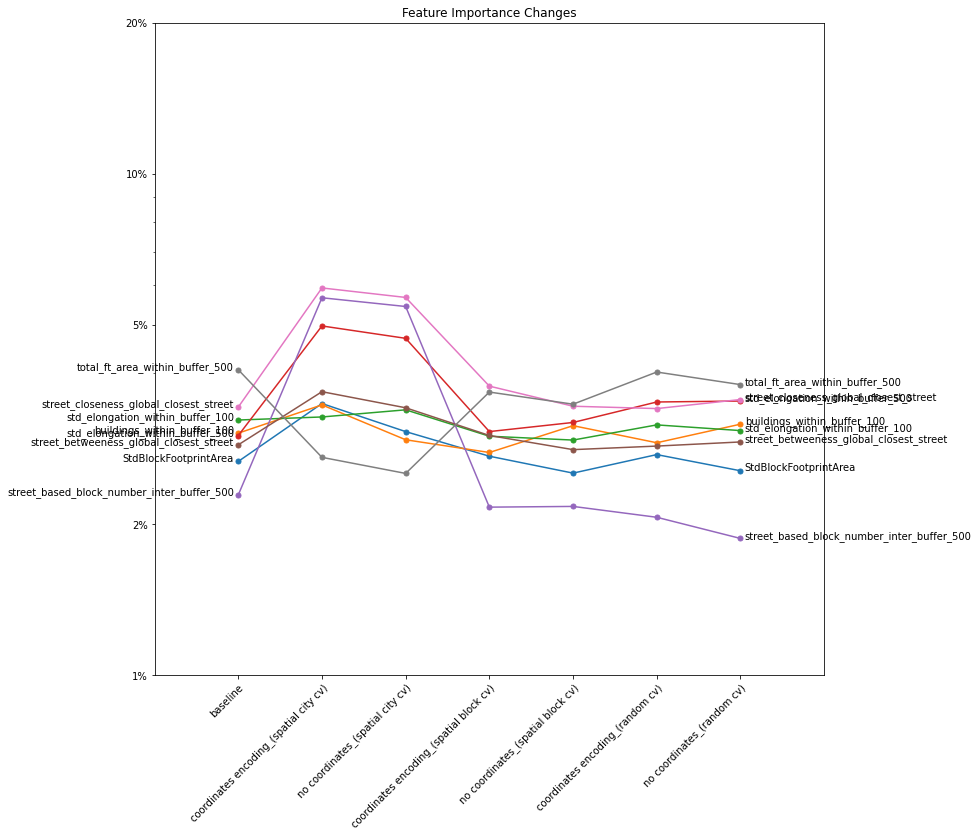

In [38]:
comparison.plot_feature_importance_changes()


In [95]:
path_test_data = os.path.join('..', 'test', 'e2e', 'test-data.csv')
test_data = pd.read_csv(path_test_data)


In [96]:
test_data = geometry.to_gdf(test_data)


In [103]:
# # moran_knn(test_data).p_norm
# import spatial_autocorrelation
# # test_data.dropna(subset=['age'], inplace=True)
# weights = spatial_autocorrelation._knn_weights(test_data, 4)

# weights.neighbors
# Moran(test_data['age'], weights).I

# moran_knn(test_data).I
print(moran_within_block(gdf_nl_sample).I)
print(moran_between_blocks(gdf_nl_sample).I)

0.2765352311896176
0.00732876237974243


In [134]:
print(moran_knn(gdf_nl_sample).I)


2022-03-28 14:34:04,855 | WARNING : /usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/esda/moran.py:1692: DeprecationWarning: invalid escape sequence \s
  """



Exception: unsupported weights transformation

In [433]:
from sklearn.neighbors import NearestNeighbors

X = gdf_nl_sample[['lat', 'lon']].values.tolist()
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [435]:
indices[6261]

array([6261,    0, 4982,  523])

In [542]:
import sklearn
# 'Apeldoorn', 'Vlieland', 'Harlingen'

# db = sklearn.cluster.DBSCAN(eps=1, min_samples=10, metric='euclidean', algorithm='auto', leaf_size=100, p=None, n_jobs=None).fit(X)
def density_based_spatial_clustering(gdf):
    coords = gdf[['lat', 'lon']].values.tolist()
    kms_per_radian = 6371.0088
    epsilon = 0.2 / kms_per_radian
    db_clusters = sklearn.cluster.DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    # db_clusters = sklearn.cluster.OPTICS(max_eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine', min_cluster_size=100).fit(np.radians(coords))
    labels  = db_clusters.labels_
    gdf['cluster'] = labels
    logger.info(f'{int(Counter(labels)[-1] / len(labels) * 100)}% of buildings remain unassigned.')

    # is_core_sample = np.zeros_like(db_clusters.labels_, dtype=bool)
    # is_core_sample[db_clusters.core_sample_indices_] = True
    # gdf['core_sample'] = is_core_sample
    # gdf['core_sample'].iloc[db_clusters.core_sample_indices_] = True
    return gdf

gdf_nl_vieland = gdf_nl[gdf_nl['city'] == 'Harlingen'].reset_index(drop=True)
gdf_nl_vieland = density_based_spatial_clustering(gdf_nl_vieland)
gdf_nl_vieland.plot(column='cluster')
gdf_nl_vieland['noisy'] = gdf_nl_vieland['cluster'] == -1
gdf_nl_vieland.plot(column='noisy')

# cluster each gadm area separately with different parameterization based on its density (area / no of buildings) when using DBSCAN or the number of buildings when using k-means (no of buildings / desired buildings per cluster)


2022-03-30 15:39:50,410 | INFO : 37% of buildings remain unassigned.


<AxesSubplot:>

In [60]:

gdf = gdf_nl[gdf_nl['city'] == 'Harlingen'].reset_index(drop=True)
gdf = preparation.add_neighborhood_column(gdf)
# gdf.plot(column='neighborhood')


gdf_2 = gpd.GeoDataFrame(gdf.copy(), geometry=gpd.points_from_xy(gdf['lon'], gdf['lat']), crs=4326)

sbb_centroids = gdf.dissolve(by='sbb').to_crs(4326).centroid
sbb_centroids_2 = gdf_2.dissolve(by='sbb').centroid
# gdf = gdf.dissolve(by='sbb')
# _, ax = plt.subplots(1, 1)

# gdf.plot(ax=ax)
# gdf.centroid.plot(ax=ax)


2022-04-12 10:42:49,902 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-12 10:42:49,999 | INFO : On average 12 street blocks have been assigned per neighborbood cluster.
2022-04-12 10:42:52,562 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-12 10:42:52,666 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [67]:
gdf['lat']

0        5.441728
1        5.434549
2        5.434593
3        5.424046
4        5.441821
           ...   
10468    5.429978
10469    5.436772
10470    5.424705
10471    5.421736
10472    5.442689
Name: lat, Length: 10473, dtype: float64

In [74]:
gdf.geometry.to_crs(4326)

0        POLYGON ((5.44183 53.17049, 5.44183 53.17049, ...
1        POLYGON ((5.43451 53.17393, 5.43451 53.17393, ...
2        POLYGON ((5.43463 53.17419, 5.43463 53.17419, ...
3        POLYGON ((5.42409 53.16795, 5.42409 53.16795, ...
4        POLYGON ((5.44175 53.16718, 5.44175 53.16718, ...
                               ...                        
10468    POLYGON ((5.42990 53.18156, 5.42990 53.18156, ...
10469    POLYGON ((5.43666 53.17880, 5.43666 53.17880, ...
10470    POLYGON ((5.42467 53.18300, 5.42467 53.18300, ...
10471    POLYGON ((5.42180 53.17688, 5.42180 53.17688, ...
10472    POLYGON ((5.44274 53.16942, 5.44274 53.16942, ...
Name: geometry, Length: 10473, dtype: geometry

In [71]:
# gdf_nl['geometry']
gdf = gdf_nl[gdf_nl['city'] == 'Harlingen'].reset_index(drop=True)

preparation.add_neighborhood_column(gdf)['geometry'].to_crs(4326)


KeyError: 'city'

In [76]:
sbb_centroids.y


sbb
162516    53.153767
162535    53.157300
162536    53.158550
162537    53.158017
162538    53.159854
            ...    
249447    53.183188
249450    53.204160
249455    53.191000
249457    53.194215
249464    53.176062
Length: 209, dtype: float64

In [72]:
sbb_centroids_2


sbb
162516    POINT (53.15621 5.43960)
162535    POINT (53.15727 5.43301)
162536    POINT (53.15851 5.43443)
162537    POINT (53.15801 5.43240)
162538    POINT (53.15986 5.43179)
                    ...           
249447    POINT (53.18319 5.44967)
249450    POINT (53.20207 5.43592)
249455    POINT (53.19120 5.43813)
249457    POINT (53.19409 5.42948)
249464    POINT (53.17605 5.42374)
Length: 209, dtype: geometry

In [6]:
gdf[['id', 'sbb', 'neighborhood']]
len(gdf['neighborhood'].unique())
len(set(labels))
gdf.plot(column='neighborhood')



NameError: name 'gdf' is not defined

In [525]:
from collections import defaultdict
%matplotlib qt
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_
db.core_sample_indices_
# core_samples, labels = cluster.dbscan(X, metric=_jw_metric, eps=.1, min_samples=2)
gdf_nl_vieland['cluster'] = db.labels_
gdf_nl_vieland.plot(column='cluster')
Counter(db.labels_)[-1] / len(db.labels_)

# regional_candidates = defaultdict(list)
# for i, label in enumerate(db.labels_):
#     regional_candidates[label].append(X[i])
# clusters = [gdf_nl_vieland[db.labels_ == n] for n in range(n_clusters_)]
# clusters
# # regional_candidates

0.037275064267352186

### Spatial cross-validation with spatial buffer

In [ ]:
df_2_borculo = df_2[df_2['city'] == 'Borculo']
b = geometry.spatial_buffer_around_block(df_2_borculo, block_type='neighborhood', buffer_size_meters=100, block_ids=[7])

2022-04-26 12:16:55,099 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 12:16:55,135 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 12:16:55,158 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
%matplotlib qt
for test, train in neighborhood_cross_validation(df):
    _, ax = plt.subplots(1, 1)
    geometry.lat_lon_to_gdf(test).plot(ax=ax, color='red')
    geometry.lat_lon_to_gdf(train).plot(ax=ax, color='blue')
    geometry.lat_lon_to_gdf(df[~df['id'].isin(list(test['id'].values) + list(train['id'].values))]).plot(ax=ax, color='grey')
    break


2022-04-26 11:35:35,189 | INFO : Reusing neighborhood column existing in data.
2022-04-26 11:35:35,262 | INFO : Using lat lon coordinates of building instead of full geometry to determine street block centroids. The result may vary slightly.
2022-04-26 11:35:35,484 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 11:35:35,528 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 11:35:35,542 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


2022-04-26 11:35:56,284 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.t

In [209]:
df_borculo['neighborhood'].value_counts()

14     4840
8       625
31      360
29      273
32      191
46      176
90      173
45      166
73      150
59      133
74      113
26       92
49       78
53       77
22       74
76       73
84       67
58       55
50       55
66       52
72       48
63       40
92       38
89       32
119      26
85       25
11       22
78       14
Name: neighborhood, dtype: int64

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
8063   -1
8064   -1
8065   -1
8066   -1
8067   -1
Name: metric_age, Length: 8068, dtype: int8

In [261]:
exp_df = df_2_borculo.copy() #.dropna(subset=['type_source'])
exp_df = categorize_age(exp_df, bins=[1900,1950,2000,2020], metric_col='metric_age')
# group_kfold = model_selection.StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
# iterator = group_kfold.split(exp_df, exp_df['age'], groups=exp_df['sbb'].values)
group_kfold = model_selection.StratifiedKFold(n_splits=5)
iterator = group_kfold.split(exp_df, exp_df['type_source'], groups=exp_df['sbb'].values)

for train_idx, test_idx in iterator:
    # print(test_idx[:10])
    print(exp_df.iloc[test_idx]['age'].value_counts())
    # test_df = exp_df.iloc[test_idx]['block'].value_counts()


2022-04-26 17:17:55,005 | INFO : age attribute has been categorized (lowest age included: 1900; highest age included: 2019).
2022-04-26 17:17:55,012 | WARNING : During age categorization 260 buildings outside the age bins have been removed.


1    1049
2     265
0     248
Name: age, dtype: int64
1    943
2    402
0    217
Name: age, dtype: int64
1    1064
0     263
2     235
Name: age, dtype: int64
1    927
2    345
0    289
Name: age, dtype: int64
1    1242
2     173
0     146
Name: age, dtype: int64


In [212]:
geometry.nearest_neighbors(df_borculo[df_borculo['neighborhood'] == 32], 0.5)

2022-04-26 16:08:42,129 | WARNING : Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




{2187654: [2187660,
  12342905,
  14905014,
  2187668,
  2187438,
  4304641,
  2187666,
  2187655,
  14904986,
  2187665,
  2187653],
 7485349: [2187515,
  2187702,
  4304631,
  7486019,
  2187493,
  2187611,
  2187449,
  2187540,
  2187228,
  2187471,
  2187444,
  4304626,
  2187467,
  2187576,
  4304635,
  2187222,
  2187701,
  2187615,
  4657586,
  2187529,
  2187440,
  2187713,
  2187524,
  2189050,
  2187843,
  2187487,
  14905294,
  2187479,
  2187885,
  2187498,
  2187832,
  14904920,
  2187553,
  2187532,
  4304639,
  14905020,
  2187475,
  2187569,
  4304582,
  2187888,
  2187477,
  2187525,
  2187250,
  2187458,
  2187223,
  2187547,
  2187584,
  2187578,
  2187571,
  2187581,
  14905002,
  2187629,
  2187886,
  2187520,
  2187624,
  2187890,
  2187560,
  2187833,
  14904946,
  2187646,
  2187837,
  2187258,
  2187549,
  14905061,
  14905053,
  7482297,
  12344925,
  2187244,
  2187677,
  4304620,
  2187607,
  2187598,
  4304628,
  14904996,
  2187592,
  4304650,
  2187538,
 

In [ ]:
_, ax = plt.subplots(1, 1)
df_2_borculo[~df_2_borculo['id'].isin(b)].plot(ax=ax, color='red')
df_2_borculo[df_2_borculo['neighborhood'] == 7].plot(ax=ax, color='green')
df_2_borculo[df_2_borculo['id'].isin(b)].plot(ax=ax, color='blue')


<AxesSubplot:>

In [ ]:
_, ax = plt.subplots(1, 1)
not_buffer = df_borculo[~df_borculo['id'].isin(b)]
geometry.lat_lon_to_gdf(not_buffer).plot(ax=ax, color='red')
block_14 = df_borculo[df_borculo['neighborhood'] == 14]
geometry.lat_lon_to_gdf(block_14_.plot(ax=ax, color='green')
buffer = df_borculo[df_borculo['id'].isin(b)]
geometry.lat_lon_to_gdf(buffer).plot(ax=ax, color='blue')


2022-04-26 12:08:37,529 | WARNING : The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.



<AxesSubplot:>